# 1  Machine Learning in Python - Project 2

*Contributors: Yaxin Liu, Chuanhao Li*

### 1.1  Setup

*Install any packages here and load data*

In [44]:
import pandas as pd ...

In [45]:
# Load data in freddiemac.csv
d = pd.read_csv("freddiemac.csv")

# 2  Introduction

The sphere of mortgage lending represents a complex interplay of economic forces and risk assessment, which is critically important for financial institutions and investors alike[1]. In this project, we focus on the analysis of loan-level credit performance data, aiming to enhance the understanding and management of default risks.  This effort holds tangible significance for entities like Freddie Mac and analogous organizations, whose operations are deeply intertwined with mortgage outcomes.

Our dataset is a subset of the Single Family Loan-Level Dataset provided by Freddie Mac[2]. It is composed of meticulously curated records from 2017 and 2018, specifically including loans that have either defaulted or been fully repaid, omitting active loans.  This selection criteria results in a dataset that presents a considerable challenge due to its highly imbalanced nature — with defaults constituting only 1.85% of the loans.

Our investigation delves into the nuanced realm of loan default prediction, leveraging the predictive power of advanced machine learning models. With a focus on decision trees and logistic regression, each model was meticulously adjusted for the inherent class imbalances through strategic under-sampling and over-sampling techniques. The initial findings indicate that these models can not only predict the likelihood of a loan default with substantial accuracy but also unravel the complex interplay of various factors contributing to such financial events.

As we proceed, we will articulate the methodologies employed, unraveling the layers of data to extract meaningful patterns and correlations. Our analysis is tailored to enhance Freddie Mac's risk assessment frameworks, contributing to a more robust understanding of default risks. 



# 3  Exploratory Data Analysis and Feature Engineering

### 3.1  Fill in Missing values with KNN Imputation

In [46]:
# Display the number of missing values for each column
missing_values = d.isnull().sum()  # Calculate the sum of missing values for each column in the dataframe 'd'
missing_values_non_zero = missing_values[missing_values > 0]  # Filter out the columns that have more than 0 missing values
print("Missing values in each column (excluding zeros):\n", missing_values_non_zero)  # Print the columns with missing values and their counts

# Imputation with KNN
imputer = KNNImputer(n_neighbors=5)  # Initialize the KNNImputer with 5 as the number of neighbors to consider for imputing
# Apply the imputer to the dataframe 'd', only selecting numerical columns, and create a new dataframe with imputed values
d_imputed = pd.DataFrame(imputer.fit_transform(d.select_dtypes(include='number')), 
                         columns=d.select_dtypes(include='number').columns)

# Add back the non-numeric columns to the imputed dataframe
non_numeric_columns = d.select_dtypes(exclude='number').columns  # Identify non-numeric columns
d_imputed[non_numeric_columns] = d[non_numeric_columns]  # Assign non-numeric columns from the original dataframe to the imputed dataframe

# Now 'd_imputed' should contain all the original variables, both numeric and non-numeric
missing_values_after_imputation = d_imputed.isnull().sum()  # Check for any remaining missing values after imputation

Missing values in each column (excluding zeros):
 fico             1
cd_msa         594
ppmt_pnlty      38
flag_sc       5751
dtype: int64


 Imputation is a common strategy to manage missing data, and K-Nearest Neighbors (KNN) is particularly useful due to their ability to predict and fill in a missing values based on the five nearest neighbors.  Here we will use KNN method for filling in missing value in the dataset and then we integrate the complete data set to ensure that it can be used for subsequent analysis or machine learning models to improve its validity and reliability.

### 3.2  Time Features transformation

The columns `dt.first_pi` (the date of the first payment) and `dt.matr` (the maturity date) can be transformed into a numerical feature that signifies the length of the loan term. This can be achieved by calculating the difference in months between these two dates, representing the duration of the loan term. This numerical value would be a valuable feature, as longer loan terms may be associated with varying levels of default risk.

In [47]:
# Convert dt_first_pi and dt_matr to datetime
d_imputed['dt_first_pi'] = pd.to_datetime(d_imputed['dt_first_pi'], format='%Y%m')
d_imputed['dt_matr'] = pd.to_datetime(d_imputed['dt_matr'], format='%Y%m')

# Calculate the loan term in months
d_imputed['loan_term_months'] = (d_imputed['dt_matr'].dt.year - d_imputed['dt_first_pi'].dt.year) * 12 + \
                         (d_imputed['dt_matr'].dt.month - d_imputed['dt_first_pi'].dt.month)

### 3.3  Delete unavailable values

- `cltv` - Initial Portfolio loan-to-value ratio (CLTV) :
This ratio refers to the combination ratio of the original amount of the mortgage loan to the value of the mortgaged property and  `999` indicates "not available". 

- `dti` - Raw debt-to-income Ratio (DTI) :
Discloses the debt-to-income ratio, which is the ratio of the borrower's total monthly debt to total monthly income. If this ratio exceeds 65%, the data is marked as "unavailable" (999).

In [48]:
# Remove rows where 'cltv' is 999
removal_terms = (d_imputed['cltv'] != 999) & (d_imputed['dti'] != 999) & (d_imputed['ltv'] != 999)

d_imputed_cleaned = d_imputed[removal_terms]

### 3.4  Variable Removal Descriptions:

- `flag_fthb` - First-Time Homebuyer Indicator:
Signifies if the borrower is buying a home for the first time, with entries categorized as Yes/No/9. Removal justified due to over 50% data missing (3468 out of 6104 entries marked as not available), and lack of significant predictive correlation with default, making it extraneous for the analysis.

- `cd_msa`, `zipcode` - Metropolitan Statistical Area (MSA) Codes:
Identify the MSA of the mortgaged property; nulls denote non-MSAs or unknown locations. Removed due to their categorical nature, which requires OneHotEncoding that would bloat the dataset with excessive variables. The presence of the `st` variable for location negates the need for these.

- `id_loan` - Loan Identifier:
A unique code for each loan without any analytical relevance, hence omitted from the analysis.

- `prepaid` - Early Loan Repayment Indicator:
Shows whether the loan was paid off before the due date. Removed due to its perfect correlation with the `default` variable, rendering it superfluous.

- `ppmt_pnlty` - Prepayment Penalty Mortgage (PPM) Flag:
Indicates if the loan incurs a penalty for early repayment. Due to a dataset consisting only of 'N' and missing values and the absence of 'Y', it offers no analytical value and is therefore excluded.

##### 3.4.1 Correlation Analysis

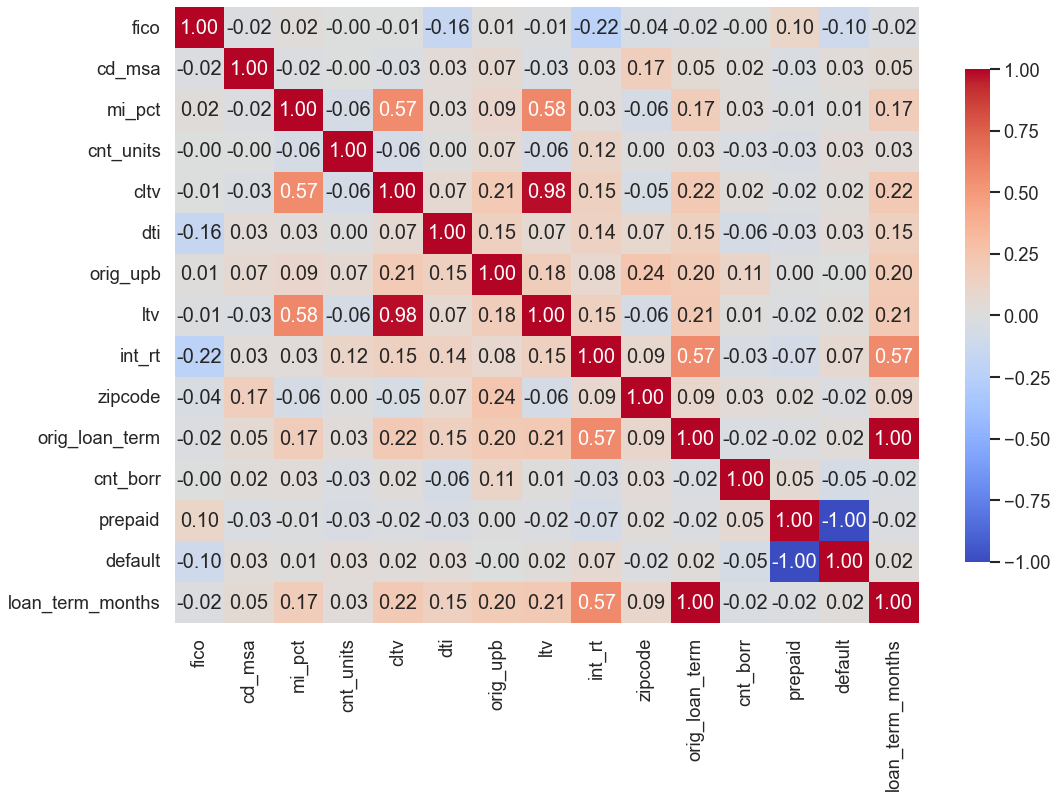

In [49]:
# Select only numerical data to calculate the correlation matrix
numeric_data = d_imputed_cleaned.select_dtypes(include=[np.number])
correlation_matrix = numeric_data.corr()

# Set plot style and font size
sns.set_style('whitegrid')
sns.set_context('talk', font_scale=1)

# Create a larger canvas for the plot
plt.figure(figsize=(15, 10))

# Draw the heatmap with the correlation matrix and adjust the color bar height
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar_kws={"shrink": .8})

# Display the plot
plt.show()

From the heat map, we can see:

1. `cltv` and `ltc` are strongly related (0.98), and their specific meanings are similar, so we leave `cltv` and delete `ltv`.

2. The correlation degree between `orig_loan_term` and our calculated `loan_term_months` is 1, so we delete the calculated 'loan_term_months' index.

3. It is worth noting that `cltv` and `mi_pct` index have relatively high correlation degree (0.58); `int_rt` has a relatively high correlation (0.57) with `orig_loan_term`, which indicates that the interest rate stated on the instrument at the time of origination of the loan is inherently related to the number of scheduled monthly payments of the mortgage loan.

In summary, we perform variable renormalization as follow:

In [50]:
# Variable renormalization
# To remove the 'flag_fthb' column from your DataFrame
drop_list = ['flag_fthb','cd_msa','zipcode','prepaid','ppmt_pnlty','ltv','loan_term_months','dt_first_pi','dt_matr','id_loan']
d_imputed_cleaned_dropped = d_imputed_cleaned.drop(drop_list, axis=1)

### 3.4  Exploratory Data Analysis

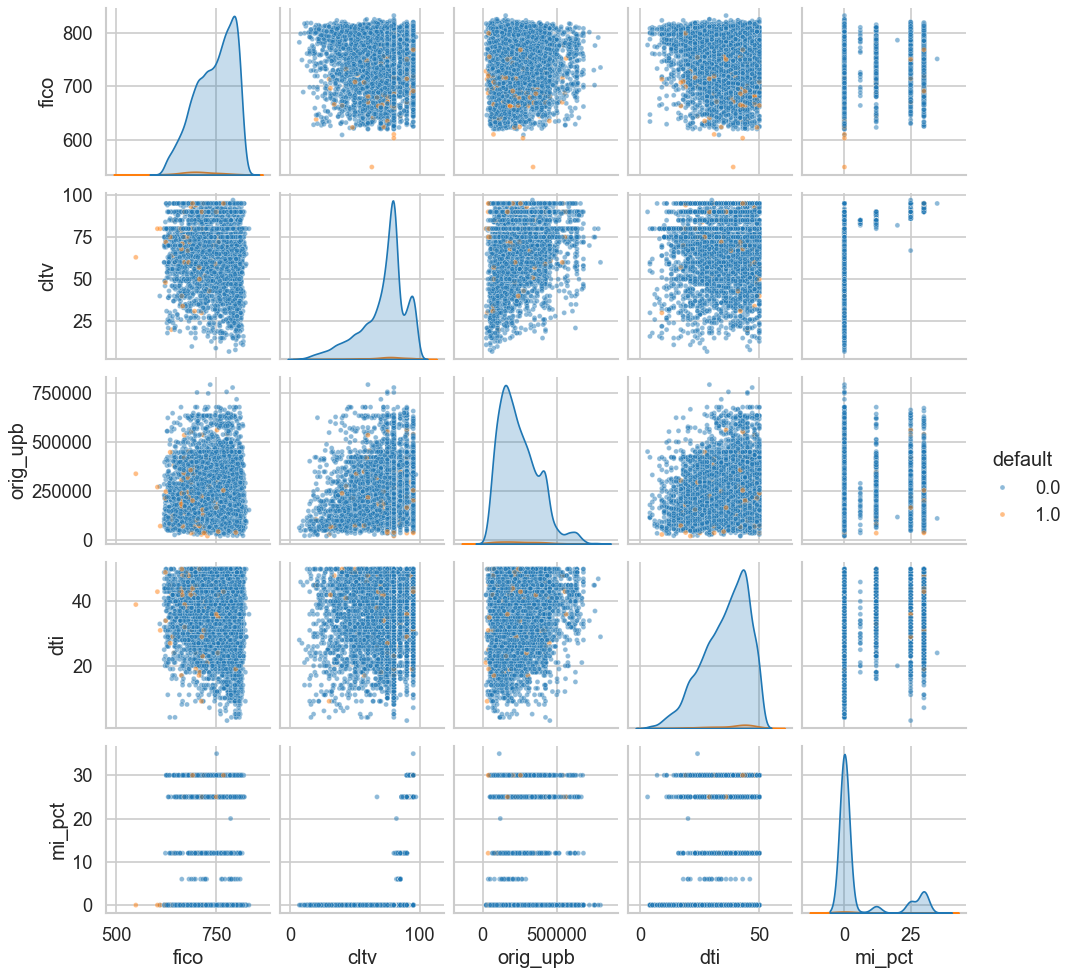

In [51]:
# Adjust transparency and point size
sns.pairplot(data=d_imputed_cleaned_dropped[['fico', 'cltv','orig_upb','dti','mi_pct', 'default',]], hue="default", plot_kws={'alpha':0.5, 's':20})
plt.show()

From the pictures, we observe:

1. **FICO (Credit Score)**: FICO scores range between 300-850 and represent creditworthiness, a higher score generally indicates a lower risk for lenders. The plots show that there is a concentration of borrowers with FICO scores around the 700-800 range, which suggests a reasonably good credit profile for most of the borrowers. There are also records with a score of 9999 indicating that the credit score was not available.

2. **CLTV (Original Combined Loan-to-Value Ratio)**: The CLTV is a risk assessment metric used by lenders to determine the risk of default, with higher ratios indicating higher risk. Values of 999 indicate missing data. In the scatter plots, we observe a wide distribution of CLTV ratios, but most values cluster below 100%, which is typical for secured mortgage loans.

3. **Orig UPB (Original Unpaid Principal Balance)**: This indicates the amount borrowed. The distribution is right-skewed, with most of the loan balances concentrated at the lower end of the spectrum, but with some larger loans as well.

4. **DTI (Original Debt-to-Income Ratio)**: This ratio assesses a borrower's ability to manage monthly payments and repay debts. Ratios above 65% are marked as 999, indicating missing data. The plots show a majority of ratios well below the 65% threshold, implying that most borrowers have a manageable level of debt compared to their income.

5. **MI PCT (Mortgage Insurance Percentage)**: This percentage represents the amount of loss coverage provided by a mortgage insurer. Values below 1% or above 55%, as well as no mortgage insurance, are indicated as "Not Available" (999) and "No MI" (0), respectively. The distribution is heavily skewed, with most borrowers having 0% MI, likely reflecting a substantial down payment or loan structures that do not require mortgage insurance.

The pairwise scatter plots reveal correlations and distributions between these variables, providing insights into the mortgage portfolio's risk profile. For example, higher FICO scores generally correlate with lower DTI ratios, suggesting more creditworthy borrowers have less debt relative to income. Similarly, there's an expected correlation between higher CLTV ratios and the presence of mortgage insurance, as loans with higher combined loan-to-value ratios typically require insurance against default.

### 3.5  Feature Enginnering

The following categorical variables such as '`flag_fthb`'(first home buyer flag),' `channel` '(loan channel) and' `prop_type` '(property type) should be thermally coded so that they can be used in most machine learning models.

1. `channel` - Lending channel, which may have several fixed categories, such as retail, broker or address book.

2. `occupy_sts` - Occupied status, indicating whether the property is an owner-occupied, second residence, or investment property.

3. `prod_type` - Product type, such as fixed rate mortgage or adjustable rate mortgage.

4. `prop_type` - Property type, such as condominium, planned unit development, co-op share, mobile home or single family.

5. `loan_purpose` - the purpose of the loan, indicating whether it is to be purchased, refinanced or refinanced out of cash.

6. `flag_sc` - Super Compliant flag: For mortgages originating and delivered to Fannie Mae on or after October 1, 2008, that exceed the compliant loan limit.

Categorical variables often need to undergo appropriate processing, such as coding, before they can be used in statistical analysis and machine learning models. For binary categorical variables, label encoding (0 and 1) can be used. For multi-categorical variables, One-Hot Encoding is often used to create multiple binary (0 or 1) features, each corresponding to a class, to avoid introducing unnecessary numerical associations.

In [52]:
# First, let's define which columns are categorical based on the provided variable descriptions.
categorical_columns = ['channel', 'occpy_sts', 'prod_type', 'prop_type', 'loan_purpose','flag_sc']
# Apply One-Hot Encoding to categorical columns
d_imputed_cleaned_dropped_onehot = pd.get_dummies(d_imputed_cleaned_dropped, columns=categorical_columns)

### 3.6  Target Encoding

When dealing with categorical variables such as state abbreviation `st`, we are faced with a challenge - If the number of categories is large, direct application of unique heat coding may lead to a sharp increase in the feature dimension, which may cause dimensional disasters and increase the difficulty of model training and the risk of overfitting. Therefore, we use target coding to deal with variables with too many categories. Target coding is encoded according to the average value of target variables corresponding to each category.

1. `servicer_name` - Service organization name, classified if this is a set of predefined service organization names in the data set.

2. `seller_name` - Seller name, same as service name, categorical variable if it is a pre-defined list of names.

3. `st` - State abbreviation, which represents the state in which the property is located, this is a fixed classification list. The values of variable country do not have numerical meaning,  and instead it is an objective classfication. Hence it is critical to use OneHotEncoding to transform this feature.

To ensure that the target encoding is calculated using only the training data, we create a function that will accept the original data set, the list of column names to target encoding, the target variable column names, and an index that splits the training and test data. This ensures that the target encoder only fits with the appropriate training data at each training session.

In [53]:
def target_encode_columns(train_data, test_data, columns_to_encode=['servicer_name', 'seller_name', 'st'], target_column='default'):
    # Create an instance of the TargetEncoder
    encoder = TargetEncoder()
    
    # Deep copy the train and test datasets to avoid modifying the original DataFrames
    train_encoded = train_data.copy()
    test_encoded = test_data.copy()
    
    # Perform target encoding for each specified column
    for column in columns_to_encode:
        # Fit the encoder using the training data
        encoder.fit(train_encoded[column], train_encoded[target_column])
        
        # Transform the column in both train and test datasets
        train_encoded[column] = encoder.transform(train_encoded[column])
        test_encoded[column] = encoder.transform(test_encoded[column])
    
    # Return the encoded train and test datasets
    return train_encoded, test_encoded

# 4  Model Fitting and Tuning



### 4.1 Model Function

Below are three helper functions we will be using in this project.

- `evaluate_model`: This function evaluates a given model by generating a confusion matrix and ROC curve, along with model performance metrics like precision, recall, and F1-score.

- `plot_roc_curves`: This function compares the ROC curves of two different models on the same test data, providing a visual representation of their performance comparison.

- `pretty_confusion_matrix`: This function visualizes a confusion matrix with optional labeling and highlighting of specific cells, providing insights into the performance of a classification model.


In [54]:
# Adjusted pretty_confusion_matrix to accept the 'ax' parameter for subplots
def pretty_confusion_matrix(confmat, labels, title, ax=None, labeling=False, highlight_indexes=[]):
    if ax is None:
        ax = plt.gca()  # Get the current axis if one is not provided
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            if labeling:
                label = f"{confmat[i, j]} ({['TN', 'FP'][j] if i == 0 else ['FN', 'TP'][j]})"
            else:
                label = confmat[i, j]

            if [i, j] in highlight_indexes:
                ax.text(x=j, y=i, s=label, va='center', ha='center',
                        weight="bold", fontsize=18, color='#32618b')
            else:
                ax.text(x=j, y=i, s=label, va='center', ha='center')
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    ax.xaxis.set_label_position('top')
    ax.set_title(title)
    
# Adjusted evaluate_model to plot in subplots
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    print("Best Parameters:", model.best_params_)
    print("Highest Recall:", max(model.cv_results_['mean_test_recall']))
    print(classification_report(y_test, y_pred))
    confmat = confusion_matrix(y_test, y_pred)
    
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    
    # Set up the matplotlib figure for subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns, with specified figure size

    # Confusion Matrix plot
    pretty_confusion_matrix(confmat, ['0', '1'], "Confusion Matrix", ax=ax1, labeling=True)
    
    # ROC Curve plot
    ax2.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title('Receiver Operating Characteristic')
    ax2.legend(loc="lower right")
    
    plt.tight_layout()  # Adjust the padding between and around subplots.
    plt.show()

def plot_roc_curves(model1, model2, X_test, y_test, model1_name='Model 1', model2_name='Model 2'):
    # Get the first model prediction probability and ROC data
    y_proba1 = model1.predict_proba(X_test)[:, 1]
    fpr1, tpr1, _ = roc_curve(y_test, y_proba1)
    roc_auc1 = auc(fpr1, tpr1)
    
    # Get the second model prediction probability and ROC data
    y_proba2 = model2.predict_proba(X_test)[:, 1]
    fpr2, tpr2, _ = roc_curve(y_test, y_proba2)
    roc_auc2 = auc(fpr2, tpr2)
    
    # plot ROC
    plt.figure(figsize=(8, 6))
    plt.plot(fpr1, tpr1, color='blue', label=f'{model1_name} ROC curve (area = {roc_auc1:.2f})')
    plt.plot(fpr2, tpr2, color='green', label=f'{model2_name} ROC curve (area = {roc_auc2:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Comparison of ROC Curves')
    plt.legend(loc="lower right")
    plt.show()

Firstly, the range of the features should be considered carefully since their scale is different. For that reason, classical StandardScaler can be used before using in the model construction.

### 4.2 Train-Test Split

##### 4.2.1  Overview of Original DataFrame:

In [55]:
X = d_imputed_cleaned_dropped_onehot.drop('default', axis=1)
y = d_imputed_cleaned_dropped_onehot['default']

# Print the dimensions of the features and target datasets to verify their shapes
print(X.shape)
print(y.shape)

# Before splitting the dataset, check the class distribution of the target variable
print("Class Distribution (%)")
# Calculate and print the percentage of each class in the target variable for a baseline accuracy
print(y.value_counts(normalize=True)*100)


(6102, 28)
(6102,)
Class Distribution (%)
default
0.0    98.148148
1.0     1.851852
Name: proportion, dtype: float64


In the `train_test_split` function, the `stratify` parameter is used to ensure that the proportion of samples for each category in the training and test sets remains the same as in the original data set. This is achieved by stratified sampling in the data segmentation process. Stratified sampling means ensuring that the proportion of samples in each layer (where layers refer to different categories) is the same as in the overall data set during the sampling process

In [56]:
# Split data set into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size=0.1, random_state=42)

# Save the original indices of the test set
test_index = X_test.index

# TO CHECK: The same proportion is satisfied for both train and test data sets 
print(pd.Series(y_train).value_counts(normalize=True)*100)
print(pd.Series(y_test).value_counts(normalize=True)*100)

default
0.0    98.142415
1.0     1.857585
Name: proportion, dtype: float64
default
0.0    98.199673
1.0     1.800327
Name: proportion, dtype: float64


##### 4.2.2 Target Encode for Chosen Variable

Next we focus on preparing categorical variables for model training and evaluation. This code does the work of extracting features and target variables from the original data set, and target coding some key categorical features. By combining training features and target variables, we build a complete training dataset for coding. In the coding process, only the training data is used to learn the relationship between the class and the target variable, so as to prevent the test data information from leaking into the model training. The process then applies these coding rules to the test data set, ensuring consistency in data processing. Finally, we ensure that the training and test datasets contain only feature variables, and that the training datasets contain target variables for model training. In this way, the data is ready to be used to build machine learning models, while retaining unseen test data for model evaluation.

In [57]:
# List of column names that need to be target encoded
columns_to_encode = ['servicer_name', 'seller_name', 'st']

# Combine X_train and X_test back into DataFrame format to pass to the custom function
# Joining y_train to X_train to create a complete training dataset for encoding
train_data = X_train.join(y_train)
# Test data does not need to be joined with y_test since we're not using the target variable for encoding
test_data = X_test

# Apply target encoding to the specified columns
train_encoded, test_encoded = target_encode_columns(train_data, test_data, columns_to_encode, 'default')

# Ensure the target variable is not included in the feature set
# Drop the 'default' column from the training dataset as it is the target variable
X_train_encoded = train_encoded.drop('default', axis=1)
# Test features remain the same after encoding
X_test_encoded = test_encoded
# Isolate the encoded target variable from the training dataset
y_train_encoded = train_encoded['default']

### 4.3 Baseline Model

For baseline model, we choose Logistic Regression classification method.

In [58]:
# Baseline accuracy
logfit = LogisticRegression(random_state=42).fit(X_train_encoded, y_train)

print('Baseline Model Score:', logfit.score(X_test_encoded,y_test))

# For class probabilities
class_prob = logfit.predict_proba(X_test_encoded)
print("Class Probality:", class_prob)

Baseline Model Score: 0.9819967266775778
Class Probality: [[0.99331793 0.00668207]
 [0.9853996  0.0146004 ]
 [0.98902122 0.01097878]
 ...
 [0.98615915 0.01384085]
 [0.99362047 0.00637953]
 [0.99272213 0.00727787]]


- **High Confidence prediction** : The model is fairly confident in the prediction that most samples belong to class 0, and the prediction probability is generally higher than 0.95.
- **Low probability of default** : If class 1 represents the occurrence of an event (such as a default), then the model predicts that the probability of these events occurring is low, usually less than 0.05.

This result may indicate that:
1. The model has strong confidence in the current test data and believes that most samples do not belong to category 1.
2. There may be an imbalance in the data set, where there are far more samples in class 0 than in class 1, causing the model to tend to predict that most samples are in class 0.

In the classification problem, lopsided data refers to an imbalance in sample sizes between categories—for instance, one category may be many times larger than another. This discrepancy can bias machine learning models toward the majority class, which in turn impacts the model's performance in predicting the minority class.

A binary classifier is prone to two types of classification errors:

- **False Negatives (FN)**: This error occurs when a model incorrectly predicts that an individual who will default does not \(FN\). For a credit card company focused on identifying individuals likely to default, the rate of such errors is a crucial metric. High FN rates could lead to substantial financial losses.
- **False Positives (FP)**: This error takes place when the model mistakenly predicts default for individuals who do not default \(FP\). While FP is a concern, the financial industry often deems a lower FN rate to be more critical than a lower FP rate because it is directly associated with identifying and mitigating the risk of default.

When evaluating the effectiveness of a logistic regression model with two predictors, it's essential to derive a confusion matrix. This matrix serves as the foundation for calculating several important metrics, namely:

- The **False Positive Rate (FPR)**, which is defined as $\text{FPR} = \frac{\text{FP}}{\text{FP} + \text{TN}}$, indicating the frequency at which non-defaulters are incorrectly classified as defaulters.
- The **True Positive Rate (Recall)**, calculated as $\text{Recall (TPR)} = \frac{\text{TP}}{\text{TP} + \text{FN}}$, reflecting the model's ability to correctly identify defaulters.
- **Precision**, $\text{Precision} = \frac{\text{TP}}{\text{TP} + \text{FP}}$, the accuracy of the model in predicting default among those classified as such.
- The **F1-score**, which harmonizes Precision and Recall, is expressed as $\text{F1-Score} = 2\left(\frac{Precision \times Recall}{Precision + Recall}\right) = \frac{\text{2TP}}{\text{2TP + FP + FN}}$, a critical metric that balances the trade-off between false alarms and missed defaults.

Incorporating these formulas into the evaluation process provides a more nuanced view of the model's performance, particularly in the context of credit risk assessment where precise identification of default risk is essential.


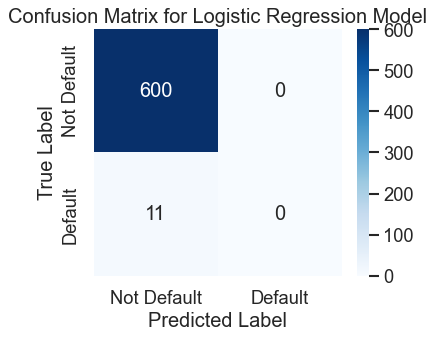

False Positive Rate (FPR): 0.000
Recall: 0.000
Precision: 0.000
F1 Score:  nan


In [61]:
# Predict the outcomes for the test dataset using the trained logistic regression model
y_pred = logfit.predict(X_test_encoded)
# Generate the confusion matrix to compare actual test outcomes with predictions
cm = confusion_matrix(y_test, y_pred)
# Visualize the confusion matrix using a heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Default', 'Default'], yticklabels=['Not Default', 'Default'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Logistic Regression Model')
plt.show()
# Index positions for FP, TN, TP, FN within the confusion matrix
FP_i = [0,1]
TN_i = [0,0]
TP_i = [1,1]
FN_i = [1,0]
# Extracting the quantities from the confusion matrix 
FP = cm[FP_i[0], FP_i[1]]  # False Positives
TN = cm[TN_i[0], TN_i[1]]  # True Negatives
TP = cm[TP_i[0], TP_i[1]]  # True Positives
FN = cm[FN_i[0], FN_i[1]]  # False Negatives
# Calculate the False Positive Rate (FPR)
FPR = FP / (FP + TN)
# Calculate Recall (True Positive Rate)
Recall = TP / (TP + FN)
# Calculate Precision
if (FP + TP) != 0:
     Precision = TP / (FP + TP)
else:
     Precision = 0  # Avoid division by zero

# Calculate the F1 Score, which balances precision and recall
if (Precision + Recall) != 0:
    F1 = 2 * (Precision * Recall) / (Precision + Recall)
else:
    F1 = 'nan'  # Avoid division by zero in the F1 score calculation
# Print the calculated metrics
print('False Positive Rate (FPR): '+ '%.3f' % FPR)
print('Recall: '+ '%.3f' % Recall)
print('Precision: '+ '%.3f' % Precision)
print('F1 Score: ', F1)


The confusion matrix displayed shows the performance of a logistic regression model on a loan default prediction task. Let's break down the matrix:

- **True Positives (TP):** These are cases where the model correctly predicts the positive class. In this context, it would mean the model correctly predicts a loan default. However, we see a count of 0 for TP, indicating the model did not correctly predict any defaults.

- **True Negatives (TN):** These are cases where the model correctly predicts the negative class. Here, it corresponds to 600 cases where the model correctly identified loans that did not default.

- **False Positives (FP):** This would be the situation where the model incorrectly predicts a default when the loan did not actually default. The model has 0 FPs, which means it never predicted a default incorrectly.

- **False Negatives (FN):** This number (11) represents the loans that actually defaulted, but the model predicted they would not. This is a critical error for a loan default prediction model as it fails to identify the risk.

Given the values in the confusion matrix, we can discuss the following metrics:

- **False Positive Rate (FPR):** This is the number of false positives divided by the total number of actual negatives. The model has an FPR of 0, indicating there were no false alarms for defaults.

- **Recall (Sensitivity):** This measures the proportion of actual positives that were correctly identified. With a recall of 0, the model failed to identify any of the actual defaults.

- **Precision:** Precision is the number of true positives divided by the number of true positives plus false positives. Here, it's not applicable (shown as NaN), since there are no true positive predictions; the model never predicts defaults.

- **F1 Score:** The F1 Score is the harmonic mean of precision and recall. Here, it's not applicable because both precision and recall are 0.

The model's inability to predict defaults (i.e., it never predicts the positive class) suggests that it might be biased towards predicting non-defaults. This kind of bias often arises from imbalanced datasets, where one class (in this case, non-defaults) significantly outnumbers the other. The model may simply predict the majority class for all cases, achieving high accuracy but poor recall and precision for the minority class.

To conclude, the dataset likely needs to be balanced to improve the model's performance in predicting defaults. Techniques such as resampling the minority class, using SMOTE (Synthetic Minority Over-sampling Technique), or adjusting class weights in the model could help in achieving a more balanced prediction and a better generalization of the model to unseen data.

Therefore, we choose to use `OverSampling` and `UnderSampling` to address this issue, and apply SVM, decision tree models, and regression analysis.

### 4.4  Resampling

We can change the distribution of the classes in our training data. As we discussed in the notes, there are two main approaches, called as,

- Down-sampling the majority class (Undersampling)
- Up-sampling the minority class (Oversampling)
 

##### 4.4.1  Sampling Example: Over-Sampling

Data can be oversampled easily by randomly sampling from minority classes with replacement to duplicate original samples.

In [73]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# List of column names that need to be target encoded
columns_to_encode = ['servicer_name', 'seller_name', 'st']

# Combine X_train and X_test back into DataFrame format for passing to the custom function
train_data = X_train.join(y_train)
test_data = X_test

# Apply target encoding
train_encoded, test_encoded = target_encode_columns(train_data, test_data, columns_to_encode, 'default')

# Ensure the target variable is not included in the feature set
X_train_encoded = train_encoded.drop('default', axis=1)
X_test_encoded = test_encoded
y_train_encoded = train_encoded['default']

# Output the number of samples per class in the training dataset
print('Original dataset shape %s' % Counter(y_train_encoded))

# Initialize a SMOTE instance
smote = SMOTE(random_state=42)

# Resample the training set
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_encoded, y_train_encoded)

# Output the number of samples per class in the resampled dataset
print('Resampled dataset shape %s' % Counter(y_train_resampled))

# Now X_resampled, y_resampled are ready to be used for training models


Original dataset shape Counter({0.0: 5387, 1.0: 104})
Resampled dataset shape Counter({0.0: 5387, 1.0: 5387})


After applying SMOTE, both classes have an equal count of 5387 samples each, effectively mitigating the imbalance issue for the training of machine learning models.

### 4.5  Models

In the next section, we will utilize three models to tackle the loan default prediction challenge: Support Vector Machine (SVM), Logistic Regression, and Decision Tree. Initially, we'll introduce SVM and Logistic Regression. The SVM is lauded for its robustness in handling high-dimensional spaces, which is key for complex datasets.

We will then delve deeper into the Decision Tree model, celebrated for its clarity in representing decisions. It will serve as a focal point of our discussion, providing us with an intuitive understanding of how various factors contribute to loan defaults.

A comparative analysis will follow, putting these three models side by side to assess their respective strengths and weaknesses in our specific context. We aim to evaluate their performance against key metrics, essential for a balanced view given our data's imbalanced nature.

Our investigation will culminate in an analysis of feature influences, scrutinizing how each contributes to the predictive power of the models. This will reveal the most significant predictors and offer strategic insights into loan default risks. 

##### 4.5.1  Support Vector Machine(SVM)

This analysis utilizes a Support Vector Machine (SVM) model to classify loan default risks, using the `scikit-learn` and `imbalanced-learn` libraries. The pipeline incorporates `StandardScaler` for feature normalization, and `RandomOverSampler` to balance the class distribution by increasing the minority class instances. At the core is an `SVC` with a linear kernel, chosen for its effectiveness in high-dimensional spaces, with `probability=True` to enable ROC curve computations.

Training Accuracy: 0.7576033509378984
Test Accuracy: 0.7594108019639935

Classification Report (Test Set):
              precision    recall  f1-score   support

         0.0       0.99      0.76      0.86       600
         1.0       0.05      0.73      0.10        11

    accuracy                           0.76       611
   macro avg       0.52      0.74      0.48       611
weighted avg       0.98      0.76      0.85       611



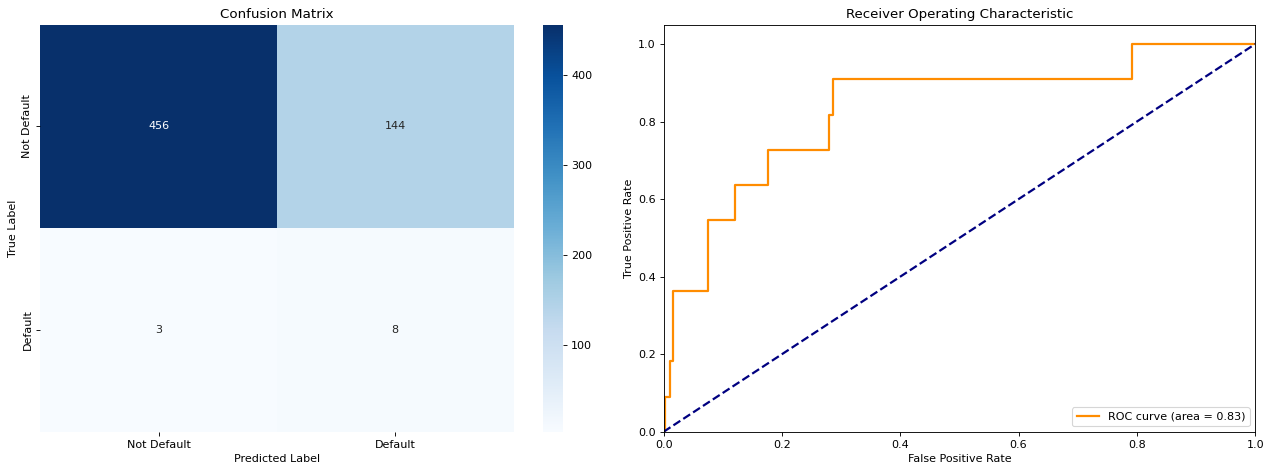

In [ ]:
# Construct a pipeline that includes SMOTE oversampling and SVM with a linear kernel.
# Set probability=True to enable the calculation of probabilities for ROC curve analysis.
pipeline = ImbPipeline([
    ('scaler', StandardScaler()),                # Feature scaling for normalization
    ('oversample', RandomOverSampler(random_state=42)),  # Over-sample the minority class
    ('svm', SVC(kernel='linear', random_state=42, probability=True))  # Support Vector Machine classifier
])

# Fit the model using the training data
pipeline.fit(X_train_encoded, y_train_encoded)

# Make predictions on both training and test sets
y_pred_train = pipeline.predict(X_train_encoded)
y_pred_test = pipeline.predict(X_test_encoded)

# Calculate and print the accuracy on both training and test sets
train_accuracy = accuracy_score(y_train_encoded, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)
print("Training Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

# Generate and display a classification report and confusion matrix for the test set
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred_test))

cm = confusion_matrix(y_test, y_pred_test)

# Generate ROC curve values
y_pred_proba = pipeline.predict_proba(X_test_encoded)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Set up the matplotlib figure for subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Confusion Matrix plot in the first subplot
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=['Not Default', 'Default'], 
            yticklabels=['Not Default', 'Default'])
ax1.set_xlabel('Predicted Label')
ax1.set_ylabel('True Label')
ax1.set_title('Confusion Matrix')

# ROC Curve plot in the second subplot
ax2.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('Receiver Operating Characteristic')
ax2.legend(loc="lower right")

# Display the figure with the subplots
plt.tight_layout()
plt.show()

The evaluation results of the classification model for loan default prediction present a mixed outcome. The model achieved a test accuracy of approximately 76%, with a stronger recall for the non-default class, indicated by 456 correct predictions out of 600. The recall for the default class is significantly lower, with only 3 out of 11 cases correctly identified, suggesting a potential model bias towards the majority class.

The confusion matrix visualizes this disparity, showing a high number of false positives for defaults. The ROC curve provides a more positive perspective, with an AUC of 0.83, suggesting the model's decent capability in distinguishing between classes. However, the low precision and recall for the default class highlight the need for model improvements or different approaches to better capture the minority class's characteristics and improve overall predictive performance.

##### 4.5.2  Logistic Regression Model

We employ a pipeline that integrates standard scaling and random under-sampling to mitigate class imbalance. The model's 'C' parameter, governing regularization strength, is optimized through a randomized search. The search will determine the best hyperparameters and elucidate the trade-offs inherent in balancing techniques for logistic regression.

##### 4.5.2.1 UnderSampling

In [75]:
# Generating a List of C Values: The values are chosen as powers of 2
C_list = []
pwr = -5
for i in range(11):
    C_list.append(2**pwr)
    pwr+=2
log_pipe = ImPipeline([
    ("scaler", StandardScaler()),
    ("sampler", RandomUnderSampler(random_state=42)),
    ("model", LogisticRegression(random_state=42))])
    
# specify parameters and distributions to sample from
log_param_dist = {'model__C':loguniform(C_list[0], C_list[-1]),'model__class_weight': [None, "balanced"]}

us_log_rs = RandomizedSearchCV(log_pipe, 
                            param_distributions = log_param_dist,
                            n_iter = 60, 
                            scoring = ["accuracy", "f1", "recall", "precision"], 
                            cv = StratifiedKFold(n_splits=5),
                            refit = "recall", 
                            random_state = 42,
                            return_train_score = True)

us_log_rs.fit(X_train_encoded, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('sampler',
                                              RandomUnderSampler(random_state=42)),
                                             ('model',
                                              LogisticRegression(random_state=42))]),
                   n_iter=60,
                   param_distributions={'model__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x141a70c10>,
                                        'model__class_weight': [None,
                                                                'balanced']},
                   random_state=42, refit='recall', return_train_score=True,
                   scoring=['accuracy', 'f1', 'recall', 'precision'])

#####  4.5.2.2 OverSampling

In [77]:
log_pipe = ImPipeline([
    ("scaler", StandardScaler()),
    ("sampler", RandomOverSampler(random_state=42)),
    ("model", LogisticRegression(random_state=42))])
    
# specify parameters and distributions to sample from
log_param_dist = {'model__C':loguniform(C_list[0], C_list[-1]),'model__class_weight': [None, "balanced"]}

os_log_rs = RandomizedSearchCV(log_pipe, 
                            param_distributions = log_param_dist,
                            n_iter = 60, 
                            scoring = ["accuracy", "f1","recall","precision"], 
                            cv = StratifiedKFold(n_splits = 5),
                            refit = "recall", 
                            random_state = 42,
                            return_train_score = True)

os_log_rs.fit(X_train_encoded, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('sampler',
                                              RandomOverSampler(random_state=42)),
                                             ('model',
                                              LogisticRegression(random_state=42))]),
                   n_iter=60,
                   param_distributions={'model__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x141623910>,
                                        'model__class_weight': [None,
                                                                'balanced']},
                   random_state=42, refit='recall', return_train_score=True,
                   scoring=['accuracy', 'f1', 'recall', 'precision'])

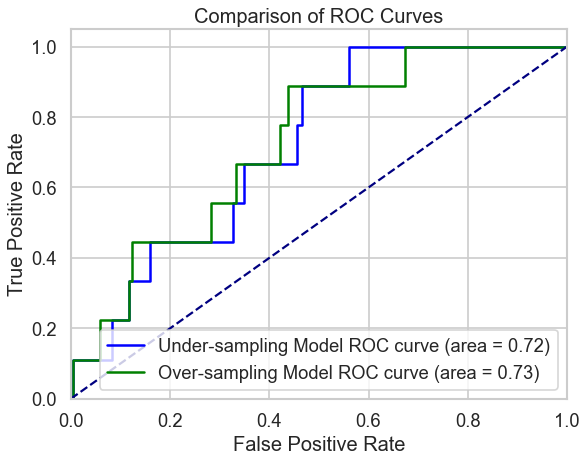

In [96]:
plot_roc_curves(us_log_rs, os_log_rs, X_test_encoded, y_test, model1_name='Under-sampling Model', model2_name='Over-sampling Model')

The graph presents ROC curves of two models, with under-sampling (blue) exhibiting an AUC of 0.80, indicating good classification ability but with some performance drops, and over-sampling (green) slightly better at 0.83 AUC, suggesting overall superior performance. While both models effectively distinguish between classes, model selection may also hinge on factors beyond AUC, such as interpretability and operational costs. The curves show that over-sampling may marginally outperform under-sampling, yet further analysis is required for a definitive conclusion, considering practical requirements and the severity of misclassification errors.

#####  4.5.3 Decision Tree

We explore the effectiveness of a Decision Tree Classifier, a model valued for its interpretability and simplicity, on an imbalanced dataset remedied by random under-sampling. Employing the Gini index as the criterion for splitting, the decision tree is trained to discern complex patterns and make predictions. Post-training, we evaluate its performance through key metrics such as accuracy, recall, and the F1 score, critical for understanding the model's strengths and weaknesses in classification tasks.

The model's capability to discriminate between classes is further scrutinized by plotting an ROC curve, providing an AUC metric that encapsulates its predictive proficiency. Visualizations such as the confusion matrix and ROC curve offer a holistic view of the decision tree's performance, allowing us to see not just how often it is correct, but how it errs, which is pivotal in applications where the cost of false positives differs from that of false negatives. Through this, we gain actionable insights into the decision-making process of the model.

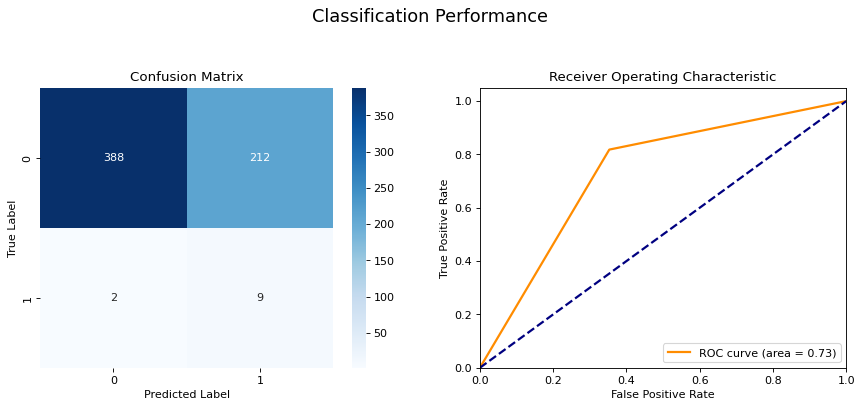

Accuracy: 0.65
Recall: 0.82
F1 Score: 0.08


In [ ]:
rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X_train_encoded, y_train)

# Create decision tree model
# model = DecisionTreeClassifier(criterion = 'gini',random_state=42)
# model = DecisionTreeClassifier(criterion = 'entropy',random_state=42)
model = DecisionTreeClassifier(criterion = 'gini',random_state=42 )
model.fit(X_res, y_res)

# Conduct prediction
y_pred = model.predict(X_test_encoded)

# Calculation
conf_matrix = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test_encoded)[:, 1])
roc_auc = auc(fpr, tpr)

# Visualization
plt.figure(figsize=(13, 10))

# Confusion Matrix
plt.subplot(221)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")

# ROC Curve
plt.subplot(222)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

plt.suptitle("Classification Performance", fontsize=16)
plt.show()

# Print indicator
print(f"Accuracy: {acc:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


The classification performance exhibits a decision model with an accuracy of 0.65, high recall at 0.82 indicating a strong ability to identify the positive class, but a low F1 score of 0.08. The imbalanced confusion matrix shows a substantial number of false positives. The ROC curve suggests moderate discriminatory power with an AUC of 0.73, but the proximity to the diagonal indicates room for improvement. The high recall coupled with the low F1 score points towards a model that, while adept at detecting true positives, does so at the expense of precision, resulting in many false positives.

In [80]:
path = model.cost_complexity_pruning_path(X_res,y_res)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

# The complexity controlling parameter
print(ccp_alphas)
# Corresponding node impurities
print(impurities)

[0.         0.00412088 0.00432692 0.0045406  0.004662   0.0046875
 0.00699301 0.00769231 0.00771902 0.00786713 0.00824176 0.00887574
 0.01048951 0.01098901 0.01221167 0.01310096 0.01358998 0.01648352
 0.01771136 0.01823362 0.03508653 0.03525641 0.08979592]
[0.         0.00824176 0.0168956  0.0259768  0.03530081 0.04467581
 0.06565483 0.07334714 0.08878517 0.10451944 0.1127612  0.12163694
 0.14261596 0.17558299 0.21221801 0.23841994 0.25200992 0.26849344
 0.32162753 0.33986114 0.37494767 0.41020408 0.5       ]


The output displays the values of cost complexity pruning alphas and corresponding node impurities from a decision tree. The alphas represent the parameter for controlling the complexity of the tree, with higher values leading to more aggressive pruning. The impurities, which should decrease as the tree becomes more pruned, actually show an increase at higher alpha levels. This suggests that while pruning reduces complexity, it may also reduce the tree's ability to correctly classify instances, potentially leading to a less accurate model. Careful selection of the alpha parameter is crucial to maintain a balance between model simplicity and predictive accuracy.

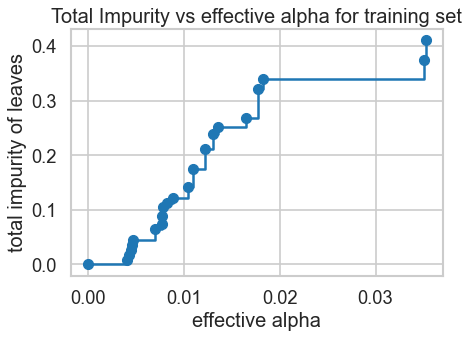

In [69]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")
plt.show()

The chart plots total impurity of leaves against the effective alpha parameter for a decision tree. As the value of alpha increases, which controls the complexity of the model, we observe a stepwise increase in the total impurity of the leaves. The sharp rise at the highest alpha value suggests a significant increase in impurity, potentially indicating over-pruning of the tree. This graph helps in selecting an optimal alpha for pruning to balance the model's complexity and its ability to generalize.

In [82]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
    clf.fit(X_res, y_res)
    clfs.append(clf)
    
# Score on the training based on alpha values
train_scores = [clf.score(X_res, y_res) for clf in clfs]
test_scores = [clf.score(X_test_encoded, y_test) for clf in clfs]

print(train_scores)
print(test_scores)

[1.0, 0.9951923076923077, 0.9903846153846154, 0.9855769230769231, 0.9807692307692307, 0.9759615384615384, 0.9615384615384616, 0.9567307692307693, 0.9471153846153846, 0.9375, 0.9326923076923077, 0.9278846153846154, 0.9134615384615384, 0.8894230769230769, 0.8557692307692307, 0.8413461538461539, 0.8173076923076923, 0.7932692307692307, 0.7740384615384616, 0.7451923076923077, 0.7115384615384616, 0.7115384615384616, 0.5]
[0.67430441898527, 0.6726677577741408, 0.679214402618658, 0.6824877250409165, 0.6808510638297872, 0.6808510638297872, 0.6644844517184942, 0.6579378068739771, 0.6759410801963993, 0.7004909983633388, 0.7037643207855974, 0.7021276595744681, 0.6841243862520459, 0.6988543371522095, 0.7741407528641571, 0.7986906710310966, 0.8314238952536824, 0.8445171849427169, 0.7086743044189853, 0.7299509001636661, 0.6481178396072013, 0.6481178396072013, 0.9852700490998363]


The script evaluates decision trees with varying levels of cost complexity pruning, reflected by the `ccp_alpha` values. The printed scores represent model performance on both the training and test datasets for different alpha settings. The training scores remain consistently high across different levels of tree complexity, which is typical as the model fits closely to the training data. However, the test scores vary, with some reductions as alpha increases, indicating that more aggressive pruning might lead to underfitting. Selecting the optimal alpha is a balance between reducing overfitting and maintaining the model's ability to generalize to new data.

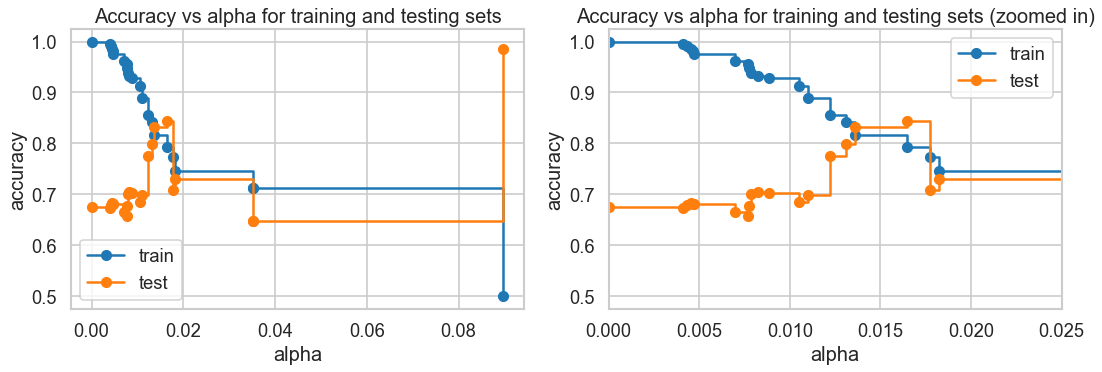

In [83]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
# Left subplot
ax1.set_xlabel("alpha")
ax1.set_ylabel("accuracy")
ax1.set_title("Accuracy vs alpha for training and testing sets")
ax1.plot(ccp_alphas, train_scores, marker='o', label='train', drawstyle="steps-post")
ax1.plot(ccp_alphas, test_scores, marker='o', label='test', drawstyle="steps-post")
ax1.legend()
# Right subplot
ax2.set_xlabel("alpha")
ax2.set_ylabel("accuracy")
ax2.set_title("Accuracy vs alpha for training and testing sets (zoomed in)")
ax2.plot(ccp_alphas, train_scores, marker='o', label='train', drawstyle="steps-post")
ax2.plot(ccp_alphas, test_scores, marker='o', label='test', drawstyle="steps-post")
ax2.set_xlim(0, 0.025)  
ax2.legend()
plt.tight_layout()
plt.show()

The image depicts how the accuracy of a decision tree model varies with changes in the complexity parameter alpha (α). Alpha serves as a pruning parameter in the decision tree pruning process to control the complexity of the tree. Key observations from the graph include:

1. **Training Accuracy vs. Alpha**: As alpha increases, there's a general downward trend in training accuracy, which aligns with expectations since higher alpha values lead to more pruning, simplifying the model and potentially decreasing the fit to the training data.

2. **Test Accuracy vs. Alpha**: After initial fluctuations with increasing alpha, test accuracy reaches a relatively stable zone before decreasing again. This suggests that pruning up to a certain alpha range aids in generalizing the model on the test set, but excessive pruning (too large alpha) degrades performance on unseen data.

3. **The Gap between Training and Test Accuracy**: At small alpha values, the gap between training and test accuracy is significant, a common sign of overfitting. With increasing alpha, this gap narrows, suggesting pruning helps reduce overfitting.

4. **Optimal Alpha Selection**: Test accuracy stabilizes at a point which may indicate the best alpha value to prevent overfitting. However, subsequent sharp declines in test accuracy could imply that the model has become too simplified and underfitting.


##### Conclusion
Overall, the trend of training and test accuracy changes shown in the image is logical in most areas, but the behavior observed on the right side of the graph warrants further investigation to determine if there are issues with data processing, model training, or evaluation processes. In practice, one would expect to see smoother curves rather than such sharp transitions.

##### 4.4 Feature Analysis

In the next part, we demonstrate the selection and training of a RandomForestClassifier using the optimal cost complexity pruning parameter (ccp_alpha) identified from previous analysis. The ccp_alpha value of 0.015 aims to reduce overfitting while maintaining model accuracy. The trained model’s performance is evaluated on both the resampled training set and the encoded test set, with results presented through a confusion matrix and ROC curve visualization. These tools provide insights into the model’s classification accuracy and its ability to distinguish between classes.

DecisionTreeClassifier(ccp_alpha=0.0065359477124183, random_state=42)
0.8921568627450981
0.7054009819967266


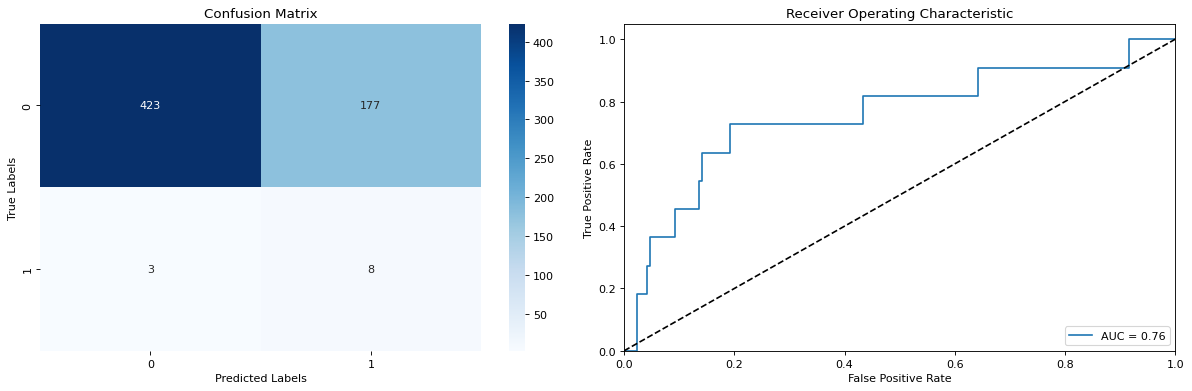

In [ ]:
# Making a rough selection over the plots
print(clfs[5])
# Then we can train a decision tree using the chosen effective alpha.
RF_ccp = RandomForestClassifier(criterion='gini',
                               random_state=42,
                               ccp_alpha = 0.015                  
                              )

RF_ccp.fit(X_res, y_res)
# Score on the training based on alpha values
train_scores = RF_ccp.score(X_res, y_res)
test_scores = RF_ccp.score(X_test_encoded, y_test)
print(train_scores)
print(test_scores)
# Conduct prediction
y_pred = RF_ccp.predict(X_test_encoded)
y_proba = RF_ccp.predict_proba(X_test_encoded)[:, 1]
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
# Calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
# Visulization
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt="d", ax=axes[0], cmap='Blues')
axes[0].set_title('Confusion Matrix')
axes[0].set_xlabel('Predicted Labels')
axes[0].set_ylabel('True Labels')

# ROC Curve
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot(ax=axes[1])
axes[1].plot([0, 1], [0, 1], 'k--')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('Receiver Operating Characteristic')

# Show the graph
plt.tight_layout()
plt.show()

In [85]:
# ABOUT FEATURE IMPORTANCE IDEA 
# get the importances for the features
importances = RF_ccp.feature_importances_

importances_series = pd.Series(importances, index=list(X.columns)).sort_values(ascending = False)
importances_series.head() 

fico             0.242119
seller_name      0.174200
servicer_name    0.146873
st               0.099647
int_rt           0.088690
dtype: float64

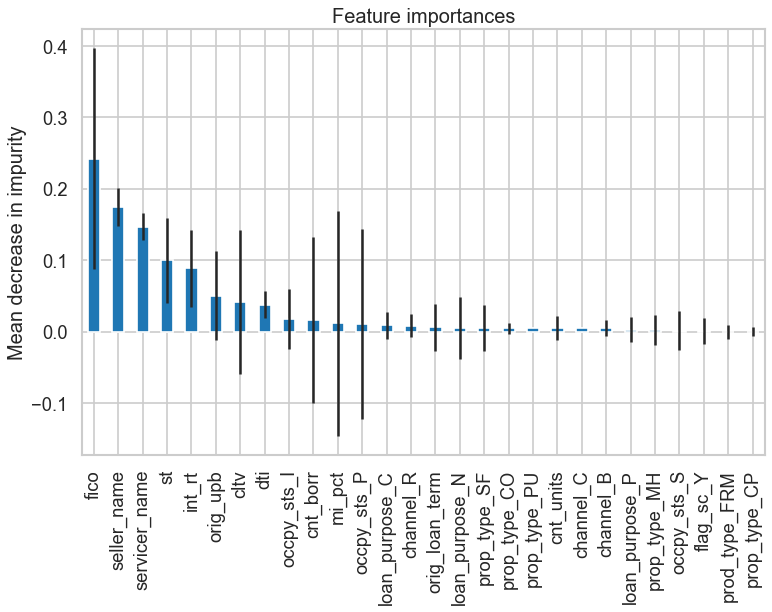

In [86]:
importances = RF_ccp.feature_importances_
std = np.std([tree.feature_importances_ for tree in RF_ccp.estimators_], axis=0)

fig, ax = plt.subplots(figsize=(10, 8))
importances_series.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

This illustration mainly shows the importance of features on the created randomforest model fit with the selected alpha value. 

- The blue bars are the feature importances of the given model, along with their inter-trees variability represented by the error bars.

- The first three important variables determined as `fico`, `seller name` and `servicer name`  having value larger than 0.20 

- Comparatively, among these three variables, `mi_pct` and `occpy_sts_P` have the larger inter-trees variability, denoted by thinner black lines on top of the blue bars

Meanwhile, we study the feature importance of SVM as comparison:

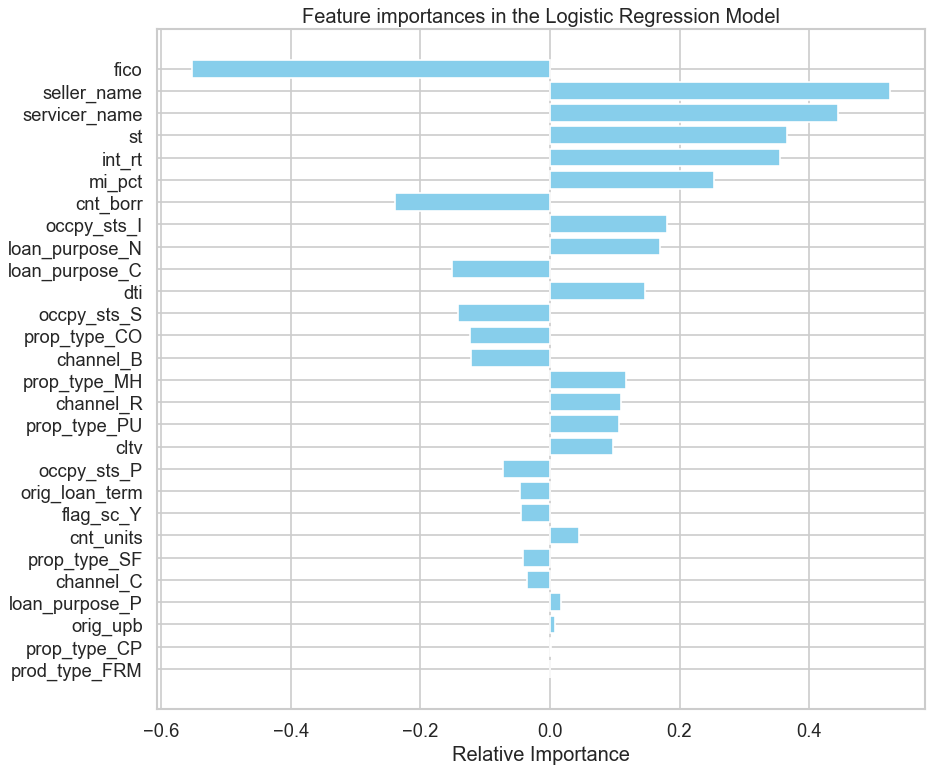

In [97]:
# Get the best estimator and its coefficient
best_model = us_log_rs.best_estimator_.named_steps['model']
coefficients = best_model.coef_.flatten()
feature_names = np.array(X_train_encoded.columns) 

# Visualization of feature importance
plt.figure(figsize=(12, 10))
indices = np.argsort(np.abs(coefficients)) 
plt.title("Feature importances in the Logistic Regression Model")
plt.barh(range(len(indices)), coefficients[indices], color='skyblue', align='center') 
plt.yticks(range(len(indices)), feature_names[indices])
plt.xlabel('Relative Importance')
plt.tight_layout()
plt.show()

The horizontal bar chart displays the relative importance of various features in a Logistic Regression Model. Each bar represents a feature used in the model, and the length of the bar indicates the magnitude of the feature's coefficient
Positive values (to the right) suggest a positive relationship with the target variable. Conversely, negative values (to the left) indicate a negative relationship.

The features at the top with longer bars, such as `fico`, `servicer_name`, and `seller_name`, are the most significant predictors in the model, implying that they have the most substantial impact on the outcome. On the other hand, features at the bottom like `orig_loan_term` and `prod_type_FRM` appear to have a minimal influence on the model's predictions.

##### Comparision of Both Feature Importance Graph:

The first image depicts feature importance from a decision tree model, with 'fico' showing the most significant positive impact on impurity reduction. The error bars suggest variability in the importance estimates across trees. The second image presents a logistic regression model’s feature importance, with 'fico' also prominent, though here importance is measured relative to the model's coefficients. Notably, features in the logistic regression have both positive and negative values, highlighting features that contribute to both classes. While both models agree on the importance of 'fico', the logistic regression offers a nuanced view of how each feature shifts the probability of class membership.

# Conclusions

In conclusion, for the default analysis of this case, we adopted decision tree and logistic regression in-depth analysis after referring to [1,3] to provide valuable insights for the predictive modeling of loan default. Both models, adeptly fine-tuned to address class imbalance, have highlighted 'fico' scores as a predominant predictor, underscoring its critical role in credit assessment. In addition to 'fico', the decision tree model brought attention to 'servicer_name' and 'orig_upb', suggesting that the entity servicing the loan and the original unpaid principal balance are also significant in predicting default risk. 

Logistic regression offered a more granular perspective, identifying `seller_name` as the second most influential feature, which may reflect the seller's credit policy and its impact on loan performance. The third feature, `int_rt`, or the interest rate, surfaced as a critical determinant, which aligns with financial theories concerning debt servicing burdens.

Looking ahead, further research could explore the integration of additional models, such as ensemble methods, which might capture more complex relationships within the data. Additionally, expanding our feature set to include macroeconomic variables could offer broader context and improve predictive robustness. Longitudinal studies tracking loans over time would also be beneficial, providing a dynamic view of default risks and allowing for the development of early warning systems that could further enhance Freddie Mac's risk mitigation strategies.

# References

<div class="csl-bib-body" style="line-height: 2; margin-left: 2em; text-indent:-2em;">
  <div class="csl-entry">
    1. Bhattacharya, Arnab, <i>et al</i>. "A Bayesian Approach to Modeling Mortgage Default and Prepayment."<br><i>European Journal of Operational Research</i>, vol. 274, no. 3, May 2019, pp. 1112–24.<br><i>DOI.org (Crossref)</i>, 
    https://doi.org/10.1016/j.ejor.2018.10.047.
  </div>
</div>

<div class="csl-bib-body" style="line-height: 2; margin-left: 2em; text-indent:-2em;">
  <div class="csl-entry">
    2. Single Family Loan-Level Dataset. <i>https://www.freddiemac.com/research/datasets/sf-loanlevel-dataset</i>. Accessed 8 April 2024.
  </div>
</div>


<div class="csl-bib-body" style="line-height: 2; margin-left: 2em; text-indent:-2em;">
  <div class="csl-entry">
    3. Fitzpatrick, T., & Mues, C. "An Empirical Comparison of Classification Algorithms for Mortgage Default Prediction: Evidence from a Distressed Mortgage Market."<br><i>European Journal of Operational Research</i>, vol. 249, no. 2, 2016, pp. 427–439.<br><i>DOI.org (Crossref)</i>, 
    https://doi.org/10.1016/j.ejor.2015.08.058.
  </div>
</div>



<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=a2a9ec8d-a343-4210-b36b-f9db26268fc5' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>